# Importing relevant functions and libraries

In [17]:
%run "Reusable_Functions.ipynb"

# Import .npz Database containing 5SS mechanisms and cplr paths

In [2]:
# Import data offline
current_dir=os.getcwd()
db_path=os.path.join(current_dir,'..','1. DB Preprocessing','norm_database5SS.npz')
db = np.load(db_path)

In [6]:
# Import data on Google CoLab
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My\ Drive/Colab\ Notebooks
db = np.load('norm_database5SS.npz')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks


In [3]:
print(db.files)
cplr=db['cplrData']
mech=db['mechData']

print(cplr.shape)
print(mech.shape)

['cplrData', 'mechData']
(1453, 100, 3)
(1453, 11, 3)


# Splitting the database in Train/Test dataset

In [4]:
x= cplr

# Split data into training and testing dataset
from sklearn.model_selection import train_test_split
x_train, x_test, _, _ = train_test_split(x, x, test_size=0.2, random_state=11)

# 3. Convolutional Autoencoders

# Simplest Autoencoder (to compare results)

Model no. 1
Restoring model weights from the end of the best epoch
Epoch 00521: early stopping
Model no. 2
Restoring model weights from the end of the best epoch
Epoch 00397: early stopping
Model no. 3
Restoring model weights from the end of the best epoch
Epoch 00502: early stopping
Model no. 4
Restoring model weights from the end of the best epoch
Epoch 00470: early stopping
Model no. 5
Restoring model weights from the end of the best epoch
Epoch 00458: early stopping
Model no. 6
Restoring model weights from the end of the best epoch
Epoch 00390: early stopping
Model no. 7
Restoring model weights from the end of the best epoch
Epoch 00548: early stopping
Model no. 8
Restoring model weights from the end of the best epoch
Epoch 00328: early stopping
Model no. 9
Restoring model weights from the end of the best epoch
Epoch 00518: early stopping
Model no. 10
Restoring model weights from the end of the best epoch
Epoch 00372: early stopping
[0.0014, 0.0019, 0.0014, 0.0016, 0.0017, 0.0015, 

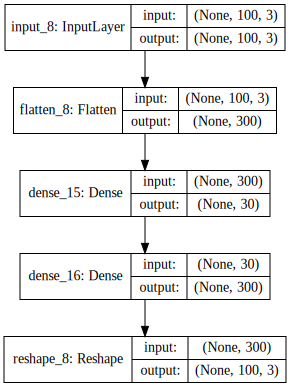

Training loss: 0.0012
Validation loss: 0.0014


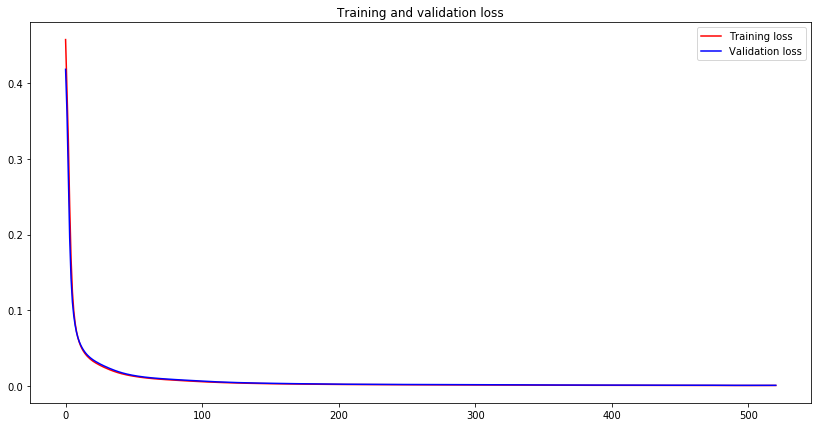

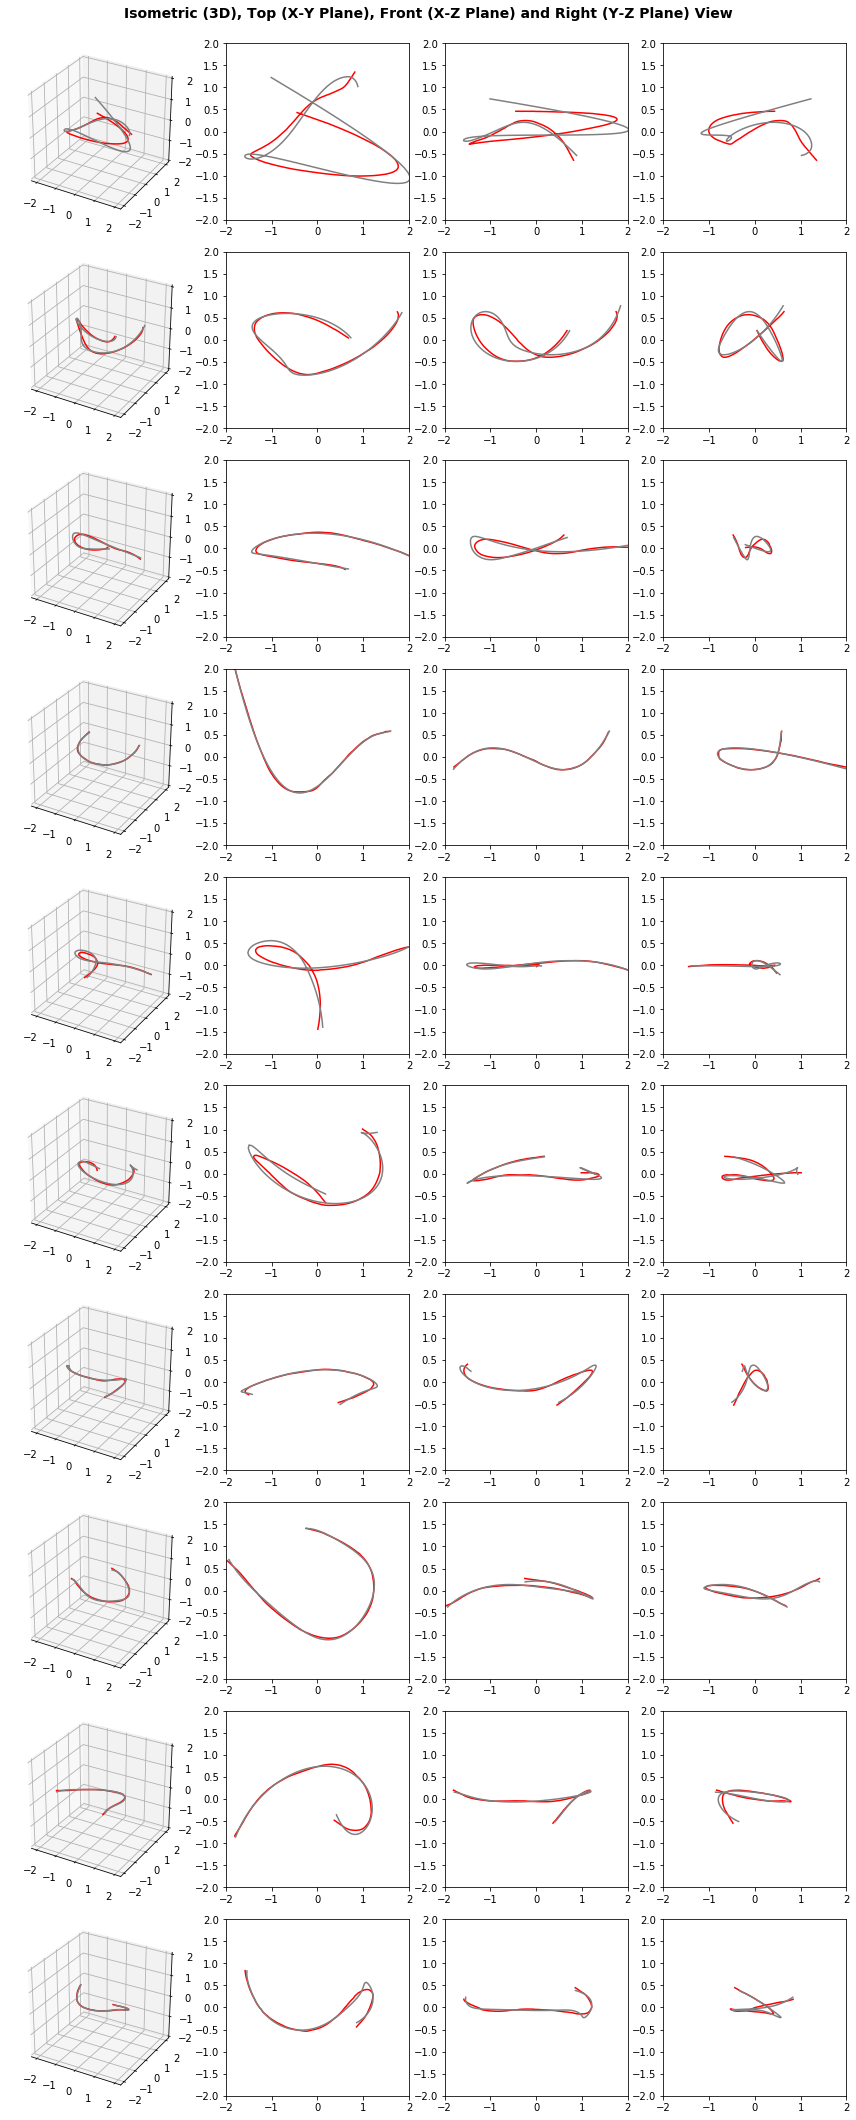

In [18]:
def autoEncoderZ30():
    inp_curve=Input(shape=(100,3))

    # Encoding
    x=Flatten()(inp_curve)
    encoded=Dense(30, activation='relu')(x)

    # Decoding
    x=Dense(300)(encoded)
    decoded=Reshape((100, 3))(x)


    autoencoder = Model(inp_curve, decoded)
    encoder = Model(inp_curve, encoded)
    
    return autoencoder, encoder

#resetRNG(0)
AE,E,train_data =AE_analysis(autoEncoderZ30, 10, x_train, x_test, filename='Z30')
visualize_AE(AE, train_data, x_test)

## 1D Convolution AutoEncoder Z=30 

Inspired to capture global convolutional features of curves like the Fourier coefficients by using full size kernels

Model no. 1
Restoring model weights from the end of the best epoch
Epoch 00227: early stopping
Model no. 2
Restoring model weights from the end of the best epoch
Epoch 00095: early stopping
Model no. 3
Restoring model weights from the end of the best epoch
Epoch 00216: early stopping
Model no. 4
Restoring model weights from the end of the best epoch
Epoch 00129: early stopping
Model no. 5
Restoring model weights from the end of the best epoch
Epoch 00151: early stopping
Model no. 6
Restoring model weights from the end of the best epoch
Epoch 00156: early stopping
Model no. 7
Restoring model weights from the end of the best epoch
Epoch 00223: early stopping
Model no. 8
Restoring model weights from the end of the best epoch
Epoch 00147: early stopping
Model no. 9
Restoring model weights from the end of the best epoch
Epoch 00160: early stopping
Model no. 10
Restoring model weights from the end of the best epoch
Epoch 00183: early stopping
[0.0031, 0.0043, 0.0037, 0.0038, 0.0031, 0.0036, 

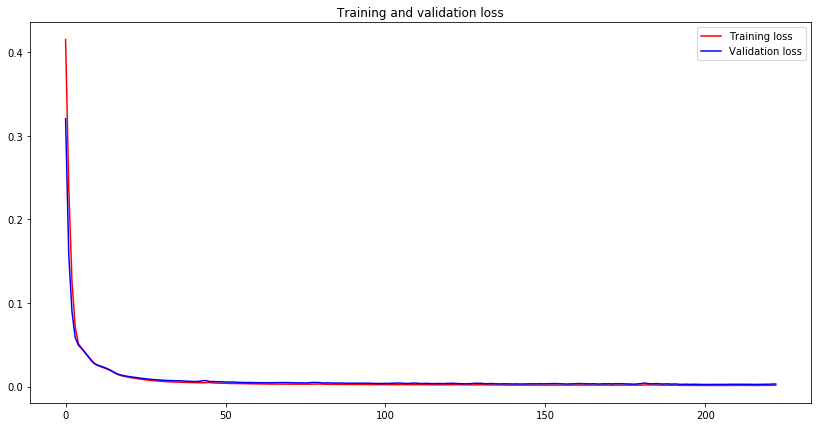

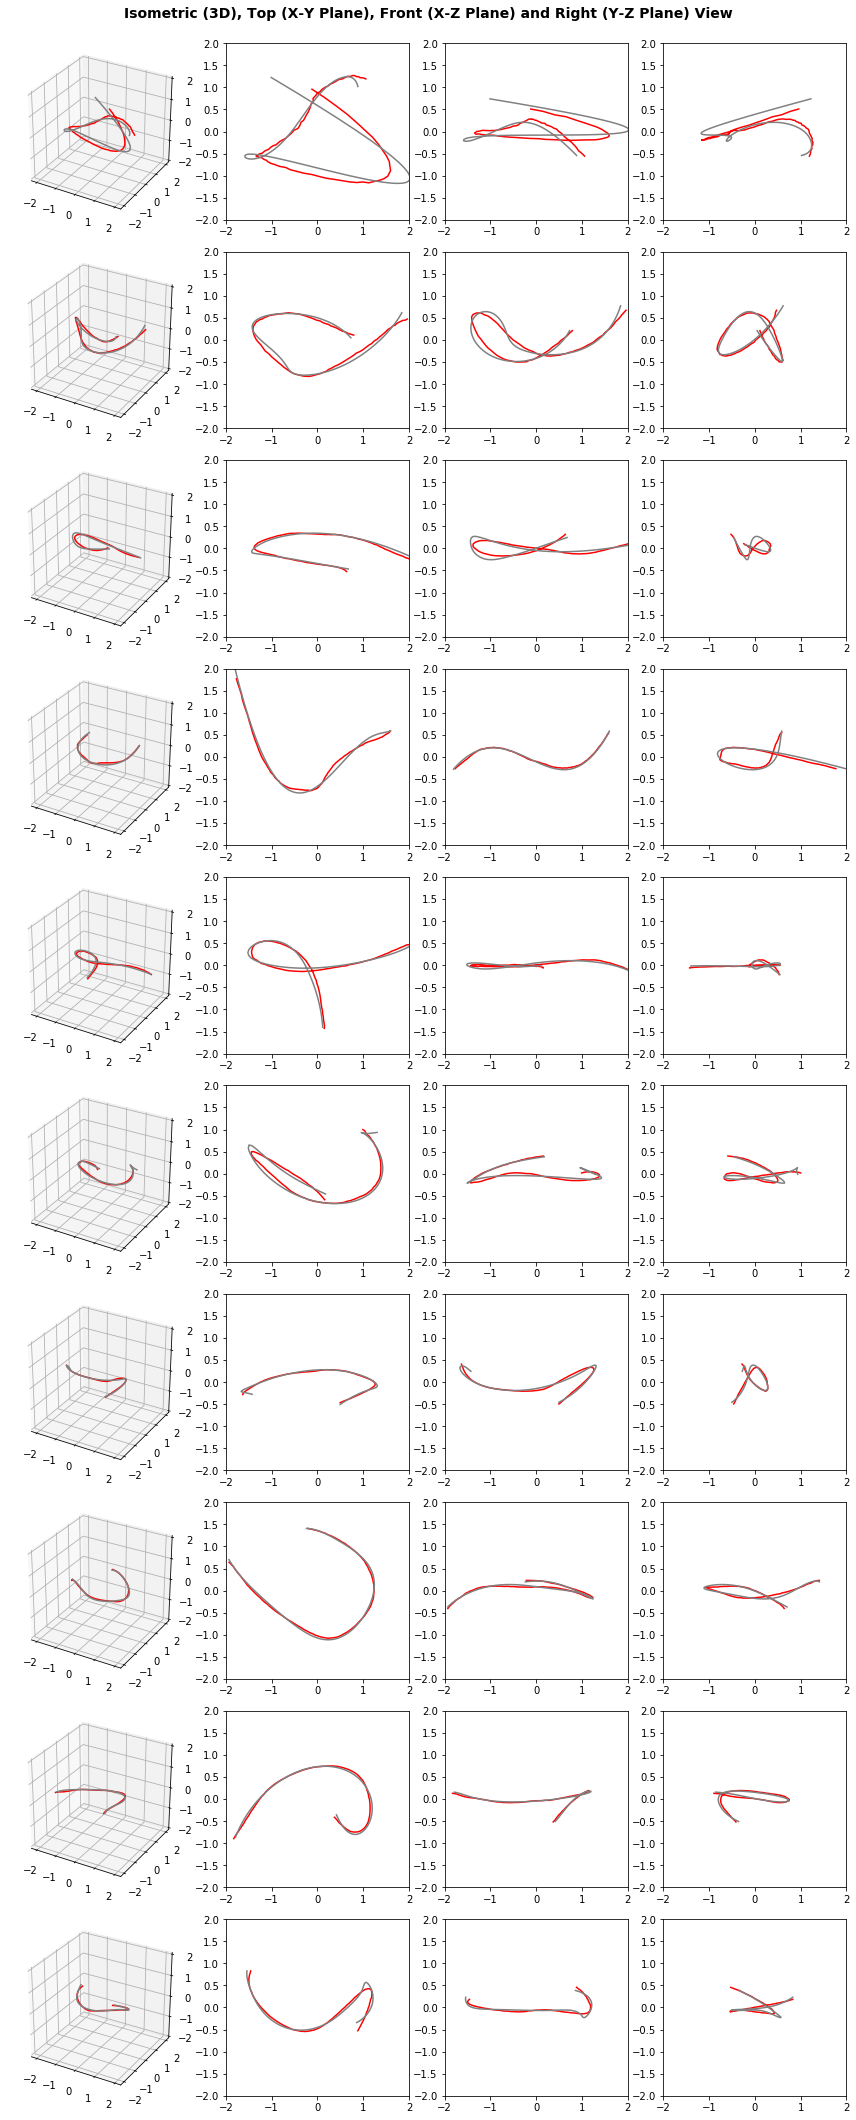

In [7]:
def autoEncoderCov_1D_Z30():
    inp_curve=Input(shape=(100,3,))

    # Encoding
    x = Conv1D(150, (100), activation='relu')(inp_curve)
    x = Flatten()(x)
    encoded=Dense(30, activation='relu')(x)
    #encoded=Dense(30, activation='relu',activity_regularizer=regularizers.l1(10e-5))(x)

    # Decoding
    x=Dense(150, activation='relu')(encoded)
    x=Reshape((150, 1))(x)
    x=Conv1D(300, (150))(x)
    decoded=Reshape((100, 3))(x)


    autoencoder = Model(inp_curve, decoded)
    encoder = Model(inp_curve, encoded)
    
    return autoencoder, encoder

#resetRNG(0)
AE,E,train_data =AE_analysis(autoEncoderCov_1D_Z30, 10, x_train, x_test, filename='Cov_1D_Z30')
visualize_AE(AE, train_data, x_test)

## 2D Convolution AutoEncoder Z=30 

Inspired to capture global convolutional features of curves like the Fourier coefficients by using full size kernels

Model no. 1
Restoring model weights from the end of the best epoch
Epoch 00265: early stopping
Model no. 2
Restoring model weights from the end of the best epoch
Epoch 00143: early stopping
Model no. 3
Restoring model weights from the end of the best epoch
Epoch 00262: early stopping
Model no. 4
Restoring model weights from the end of the best epoch
Epoch 00145: early stopping
Model no. 5
Restoring model weights from the end of the best epoch
Epoch 00114: early stopping
Model no. 6
Restoring model weights from the end of the best epoch
Epoch 00126: early stopping
Model no. 7
Restoring model weights from the end of the best epoch
Epoch 00231: early stopping
Model no. 8
Restoring model weights from the end of the best epoch
Epoch 00134: early stopping
Model no. 9
Restoring model weights from the end of the best epoch
Epoch 00221: early stopping
Model no. 10
Restoring model weights from the end of the best epoch
Epoch 00265: early stopping
[0.0037, 0.0069, 0.0032, 0.0061, 0.0072, 0.0066, 

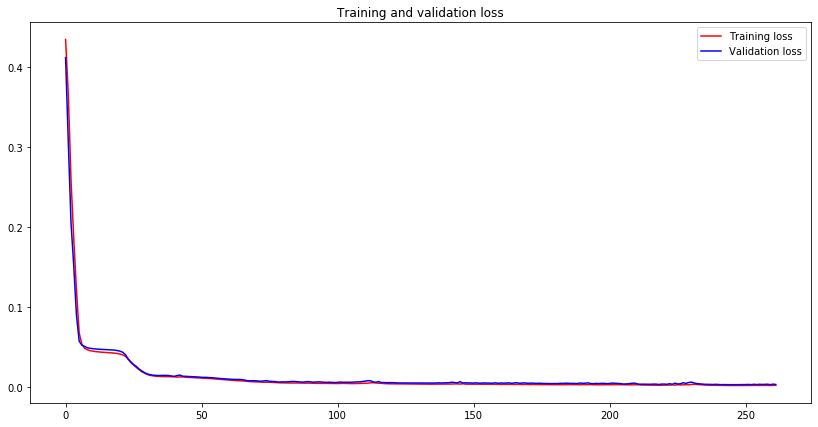

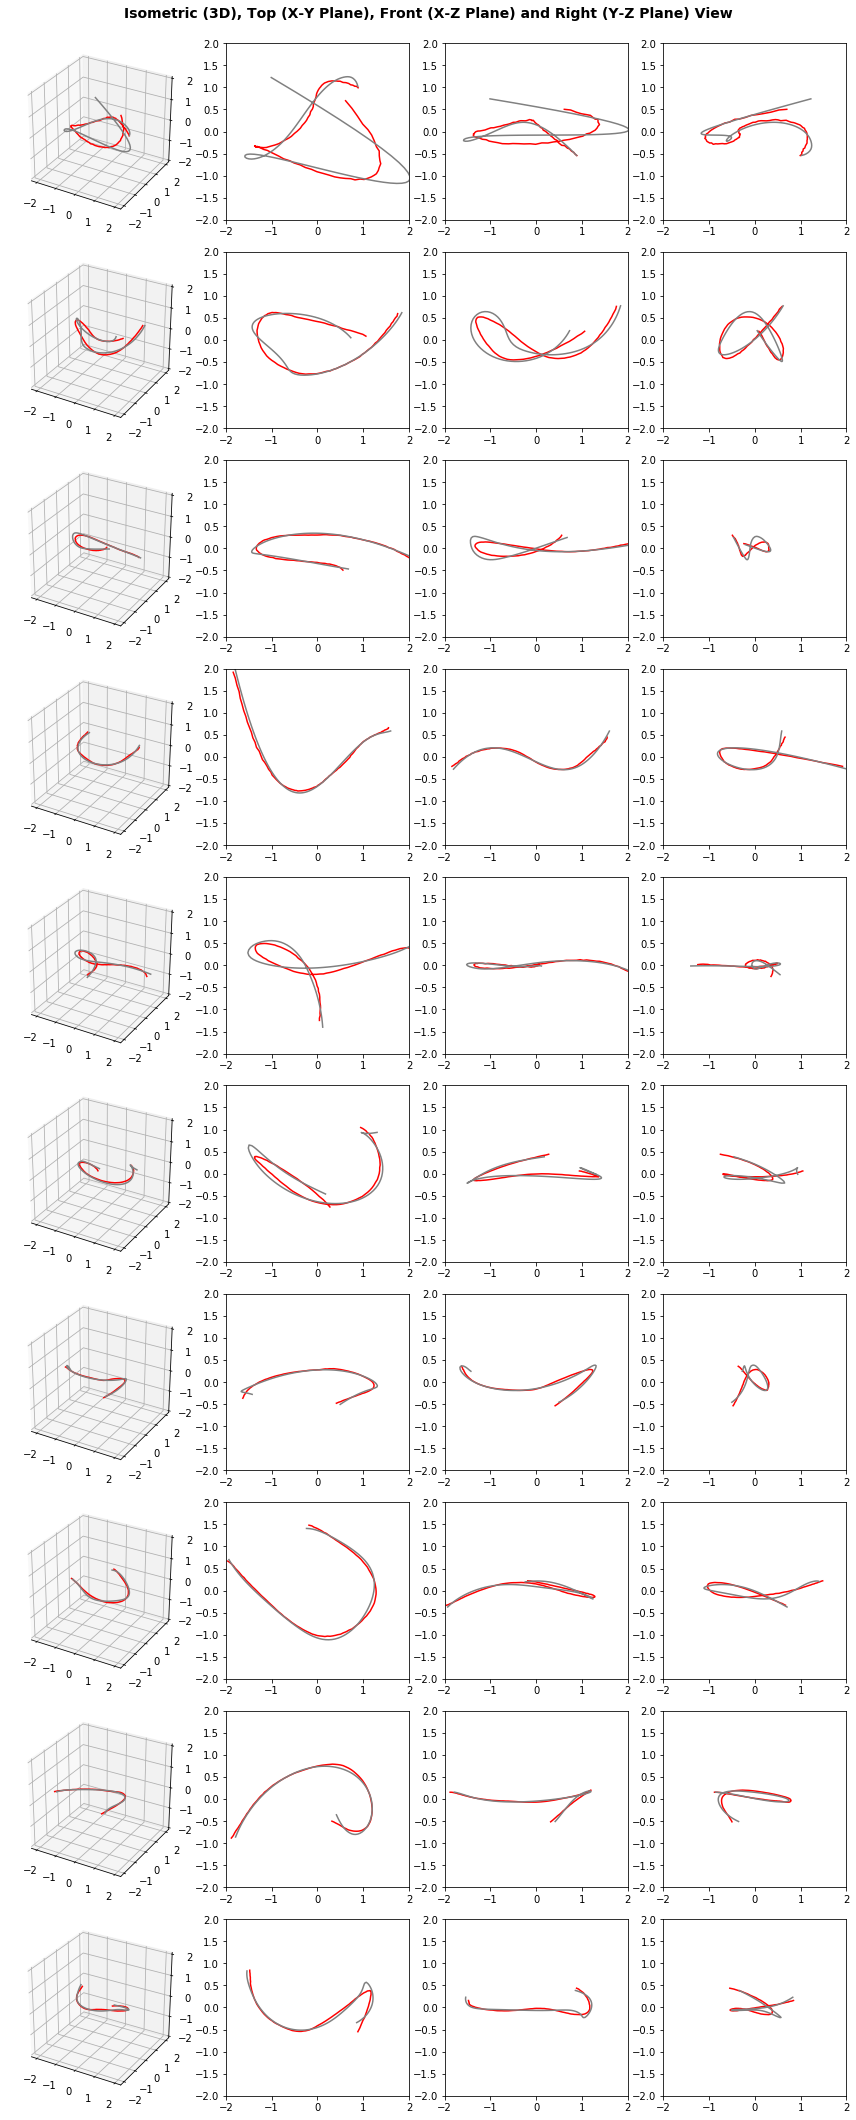

In [19]:
def autoEncoderCov_2D_Z30():
    inp_curve=Input(shape=(100,3))

    # Encoding
    x= Reshape((100, 3, 1))(inp_curve)
    x= Conv2D(50, (100,1), activation='relu')(x)
    x=Flatten()(x)
    x=Dense(100, activation='relu')(x)
    encoded=Dense(30, activation='relu')(x)

    # Decoding
    #x=Dense(100, activation='relu')(encoded)
    #x=Dense(150, activation='relu')(x)
    #x=Reshape((3, 50, 1))(x)
    #x=Conv2D(100, (1,50))(x)
    #decoded=Reshape((100, 3))(x)
    
    # Decoding
    x=Dense(100, activation='relu')(encoded)
    x=Dense(150, activation='relu')(x)
    x=Reshape((1, 3, 50))(x)
    x=Conv2DTranspose(1,(100,1))(x)
    decoded=Reshape((100, 3))(x)


    autoencoder = Model(inp_curve, decoded)
    encoder = Model(inp_curve, encoded)
    
    return autoencoder, encoder

#resetRNG(0)
#x_train_3D=np.expand_dims(x_train, 4)
#x_test_3D=np.expand_dims(x_test, 4)
AE,E,train_data =AE_analysis(autoEncoderCov_2D_Z30, 10, x_train, x_test, filename='Cov_2D_Z30')
visualize_AE(AE, train_data, x_test)

## Custom Convolution Autoencoder Z=30

Inspired to capture local convolutional features of curves like the Wavelet coefficients

Model no. 1
Restoring model weights from the end of the best epoch
Epoch 00164: early stopping
Model no. 2
Restoring model weights from the end of the best epoch
Epoch 00139: early stopping
Model no. 3
Restoring model weights from the end of the best epoch
Epoch 00110: early stopping
Model no. 4
Restoring model weights from the end of the best epoch
Epoch 00162: early stopping
Model no. 5
Restoring model weights from the end of the best epoch
Epoch 00131: early stopping
Model no. 6
Restoring model weights from the end of the best epoch
Epoch 00132: early stopping
Model no. 7
Restoring model weights from the end of the best epoch
Epoch 00093: early stopping
Model no. 8
Restoring model weights from the end of the best epoch
Epoch 00212: early stopping
Model no. 9
Restoring model weights from the end of the best epoch
Epoch 00119: early stopping
Model no. 10
Restoring model weights from the end of the best epoch
Epoch 00153: early stopping
[0.0108, 0.0093, 0.0104, 0.01, 0.01, 0.0147, 0.01

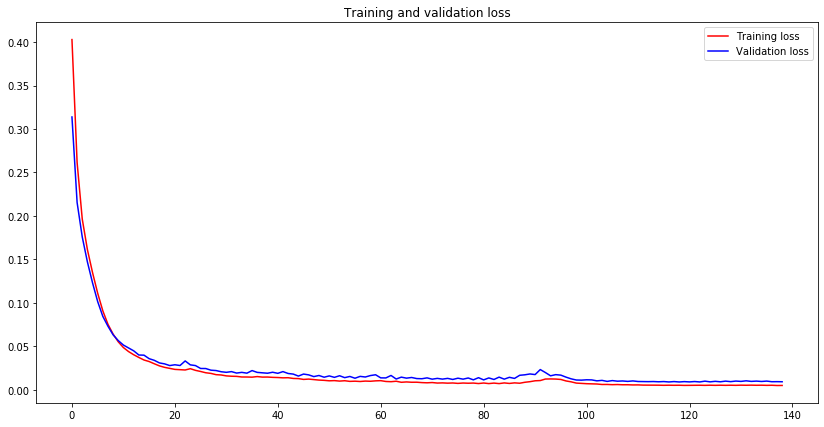

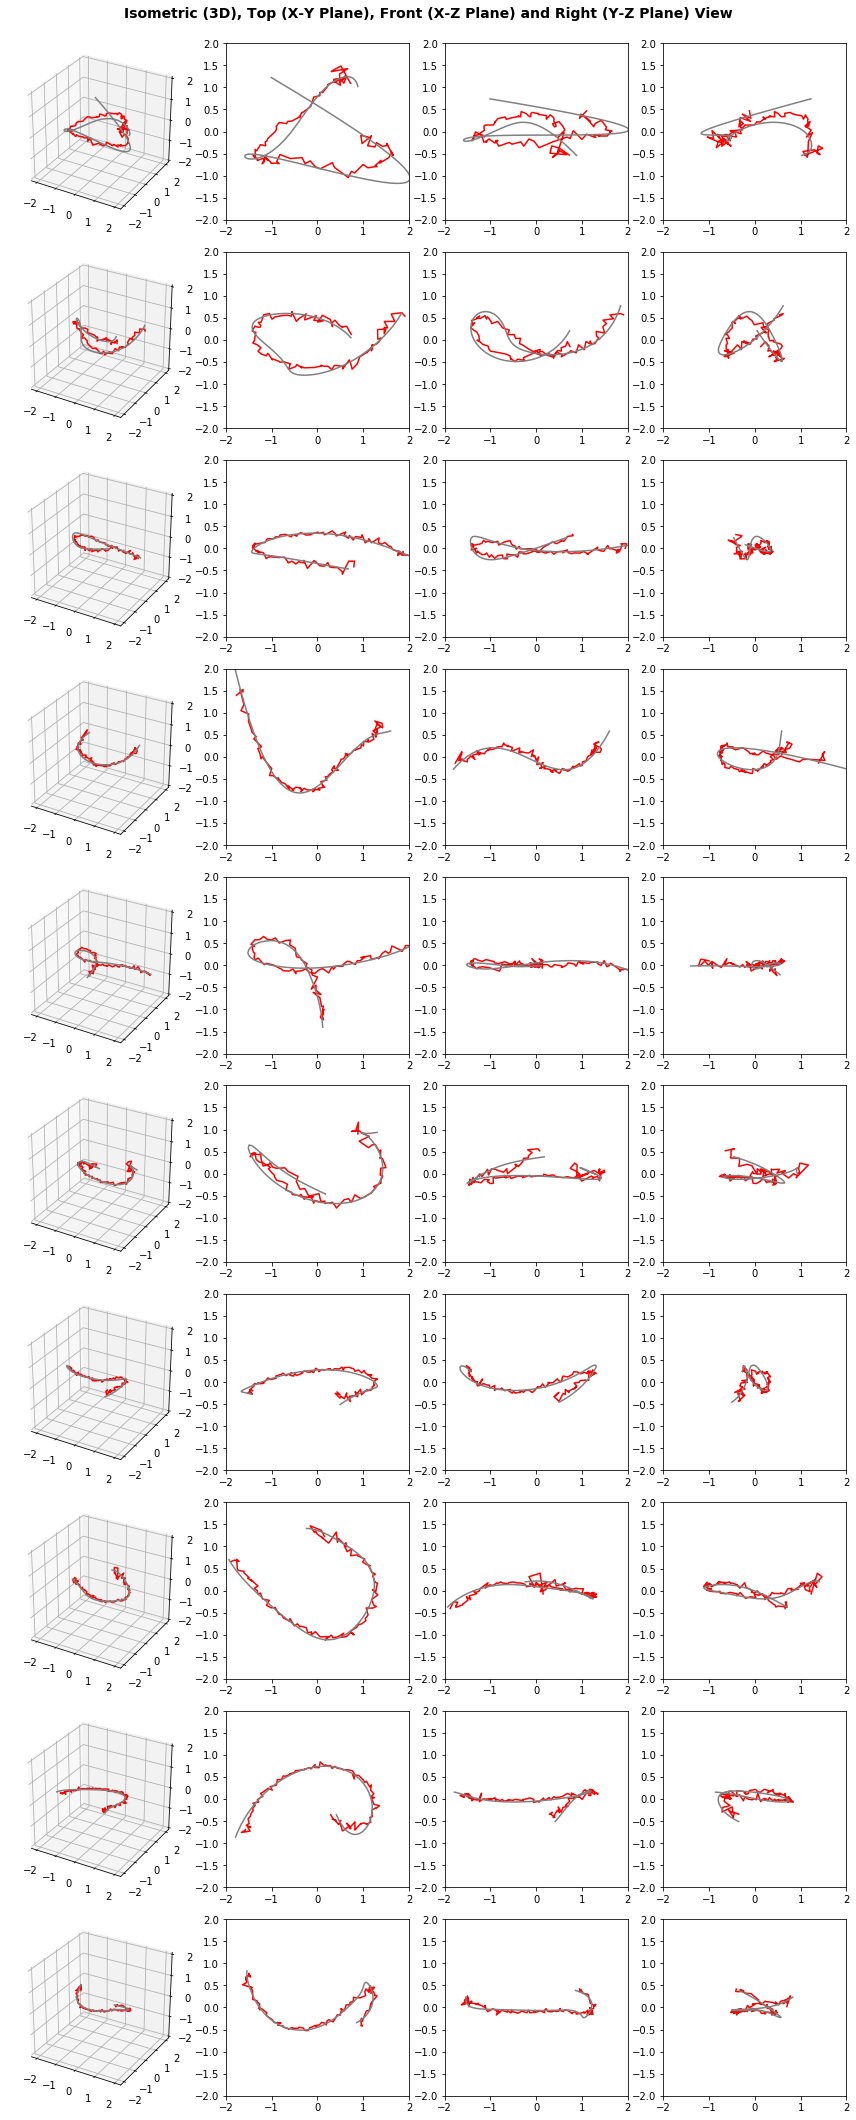

In [0]:
from keras.layers import Add, MaxPooling1D, UpSampling1D, MaxPooling2D

def autoEncoderCov_custom_Z30():
    inp_curve=Input(shape=(100,3,))

    # Encoding
    x= Reshape((100, 3, 1))(inp_curve)
    x1=Conv2D(4,(5,3), activation='relu')(x)
    x1=MaxPooling2D((2,1))(x1)
    x1=Flatten()(x1)
    x2=Conv2D(4,(20,3), activation='relu')(x)
    x2=MaxPooling2D((2,1))(x2)
    x2=Flatten()(x2)
    x3=Conv2D(4,(50,3), activation='relu')(x)
    x3=MaxPooling2D((2,1))(x3)
    x3=Flatten()(x3)
    x=concatenate([x1,x2,x3], axis=1)
    x=Dense(100, activation='relu')(x)
    encoded=Dense(30, activation='relu')(x)

    # Decoding
    x=Dense(100, activation='relu')(encoded)
    x=Dense(452, activation='relu')(x)
    x=UpSampling1D(2)(x)
    x=Dense(300,activation='relu')(x)
    x=Reshape((300, 1, 1))(x)
    x1=Conv2D(4,(5,1),padding='same', activation='relu')(x)
    x2=Conv2D(4,(20,1),padding='same', activation='relu')(x)
    x3=Conv2D(4,(50,1),padding='same', activation='relu')(x)
    x=Add()([x1, x2, x3])
    x=Conv2D(1,(5,1),padding='same')(x)
    decoded=Reshape((100,3))(x)

    autoencoder = Model(inp_curve, decoded)
    encoder = Model(inp_curve, encoded)
    
    return autoencoder, encoder

AE,E,train_data =AE_analysis(autoEncoderCov_custom_Z30, 10, x_train, x_test, filename='Cov_custom_Z30')
visualize_AE(AE, train_data, x_test)

## Pure FFT AutoEncoder Z=30

Model no. 1
Restoring model weights from the end of the best epoch
Epoch 00316: early stopping
Model no. 2
Restoring model weights from the end of the best epoch
Epoch 00334: early stopping
Model no. 3
Restoring model weights from the end of the best epoch
Epoch 00191: early stopping
Model no. 4
Restoring model weights from the end of the best epoch
Epoch 00186: early stopping
Model no. 5
Restoring model weights from the end of the best epoch
Epoch 00225: early stopping
Model no. 6
Restoring model weights from the end of the best epoch
Epoch 00213: early stopping
Model no. 7
Restoring model weights from the end of the best epoch
Epoch 00136: early stopping
Model no. 8
Restoring model weights from the end of the best epoch
Epoch 00165: early stopping
Model no. 9
Restoring model weights from the end of the best epoch
Epoch 00242: early stopping
Model no. 10
Restoring model weights from the end of the best epoch
Epoch 00232: early stopping
[0.0017, 0.0017, 0.0023, 0.0027, 0.0018, 0.002, 0

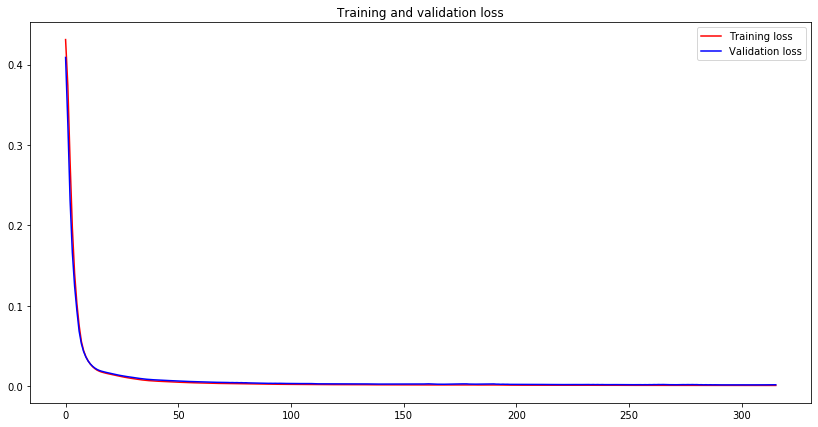

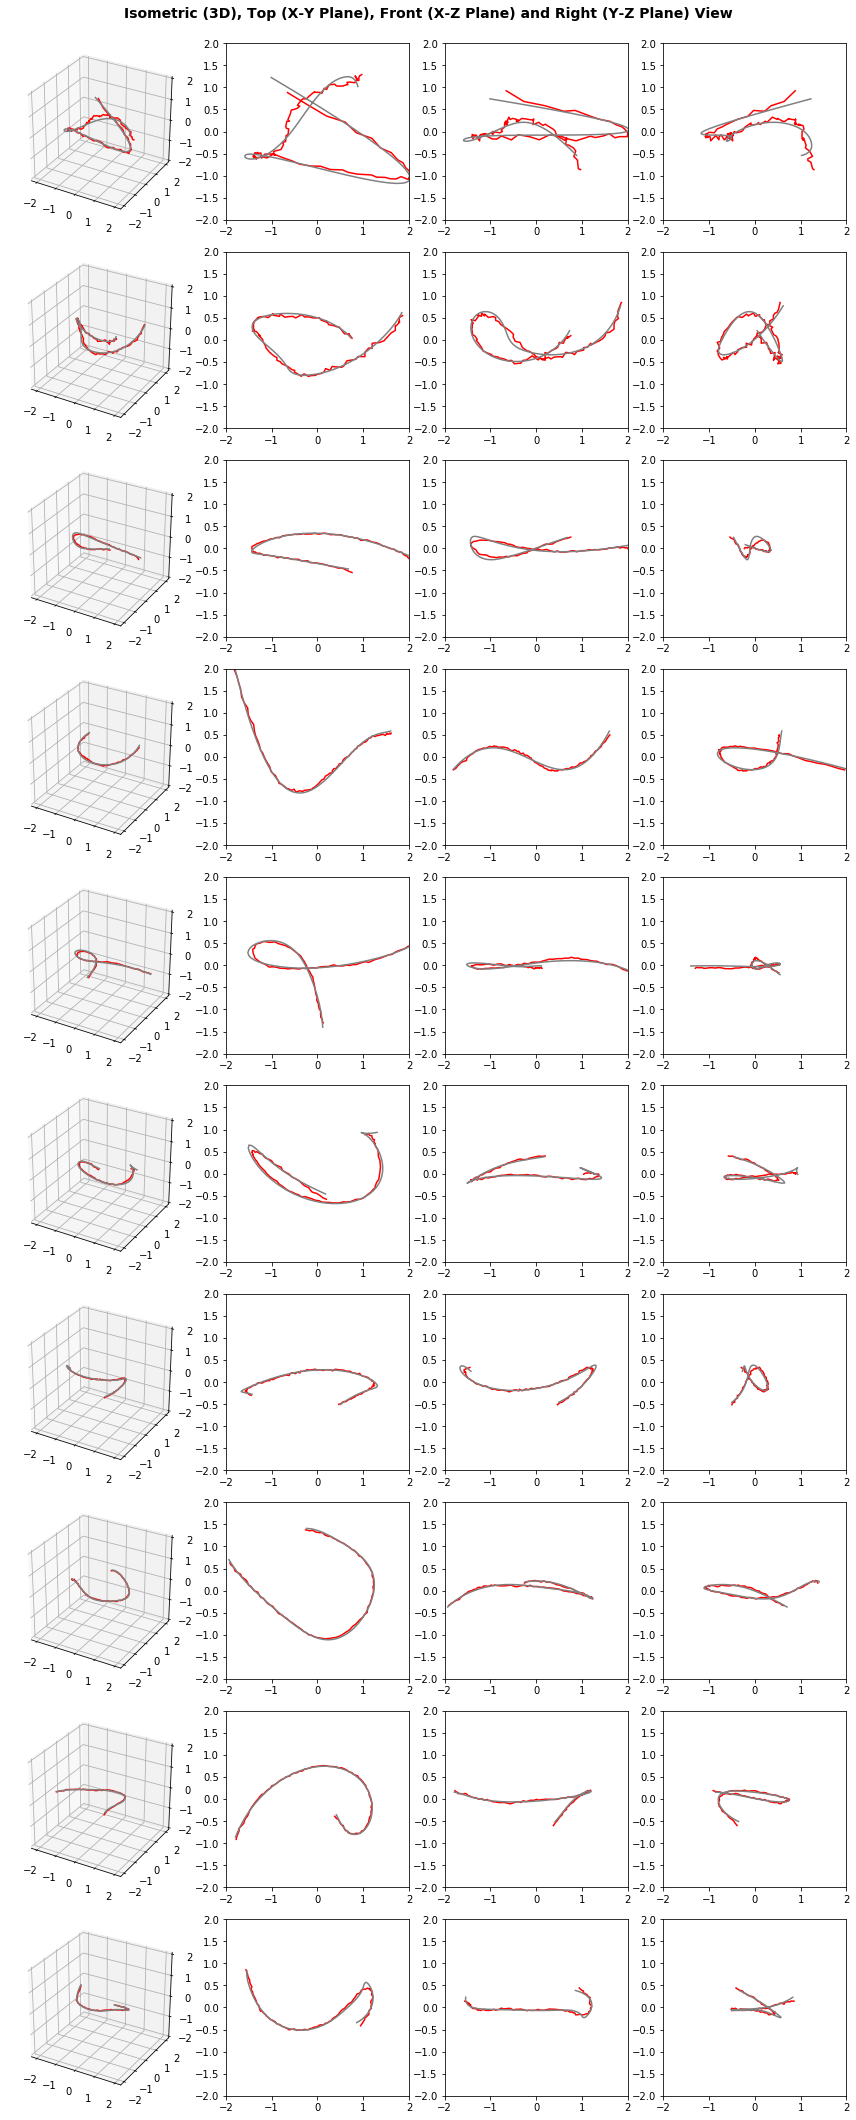

In [0]:
from keras.layers import Permute

def Fourier(x):
    #return tf.cast(tf.spectral.fft(tf.cast(x,dtype=tf.complex64)),dtype=tf.float32)
    FDs=tf.spectral.rfft(x)
    re=tf.cast(tf.real(FDs),dtype=tf.float32)
    im=tf.cast(tf.imag(FDs),dtype=tf.float32)
    return tf.concat([re,im],-1)

def invFourier(x):
    #return tf.cast(tf.spectral.ifft(tf.cast(x,dtype=tf.complex64)),dtype=tf.float32)
    re,im=tf.split(x,2,-1)
    FDs=tf.complex(re,im)
    curve=tf.spectral.irfft(FDs)
    return curve

def autoEncoderFFT_Z30():
    inp_curve=Input(shape=(100,3))

    # Encoding
    x= Permute((2, 1))(inp_curve)
    x = Lambda(Fourier)(x)
    x=Flatten()(x)
    x=Dense(150, activation='relu')(x)
    encoded=Dense(30, activation='relu')(x)

    # Decoding
    x=Dense(150, activation='relu')(encoded)
    x=Dense(306)(x)
    x=Reshape((3, 102))(x)
    x = Lambda(invFourier)(x)
    decoded= Permute((2, 1))(x)

    autoencoder = Model(inp_curve, decoded)
    encoder = Model(inp_curve, encoded)
    
    return autoencoder, encoder

#resetRNG(0)
#x_train_3D=np.expand_dims(x_train, 4)
#x_test_3D=np.expand_dims(x_test, 4)
AE,E,train_data =AE_analysis(autoEncoderFFT_Z30, 10, x_train, x_test, filename='FFT_Z30')
visualize_AE(AE, train_data, x_test)

## Variational Autoencoder Z=30

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 100, 3)       0                                            
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 300)          0           input_2[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 150)          45150       flatten_1[0][0]                  
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 30)           4530        dense_1[0][0]                    
____________________________________________________________________________________________

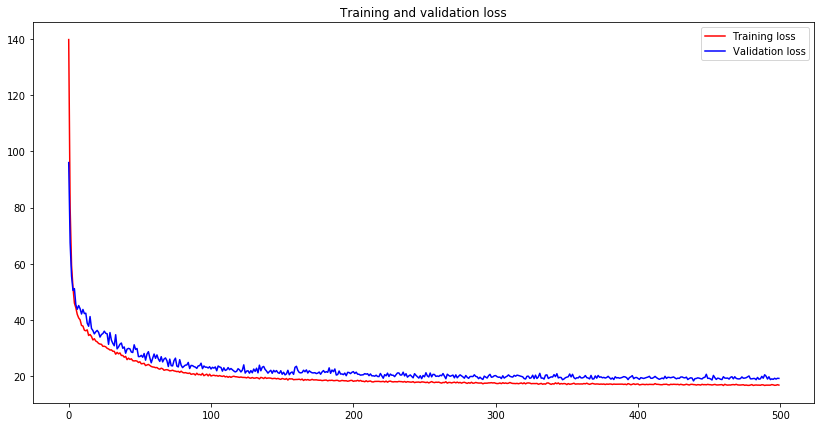

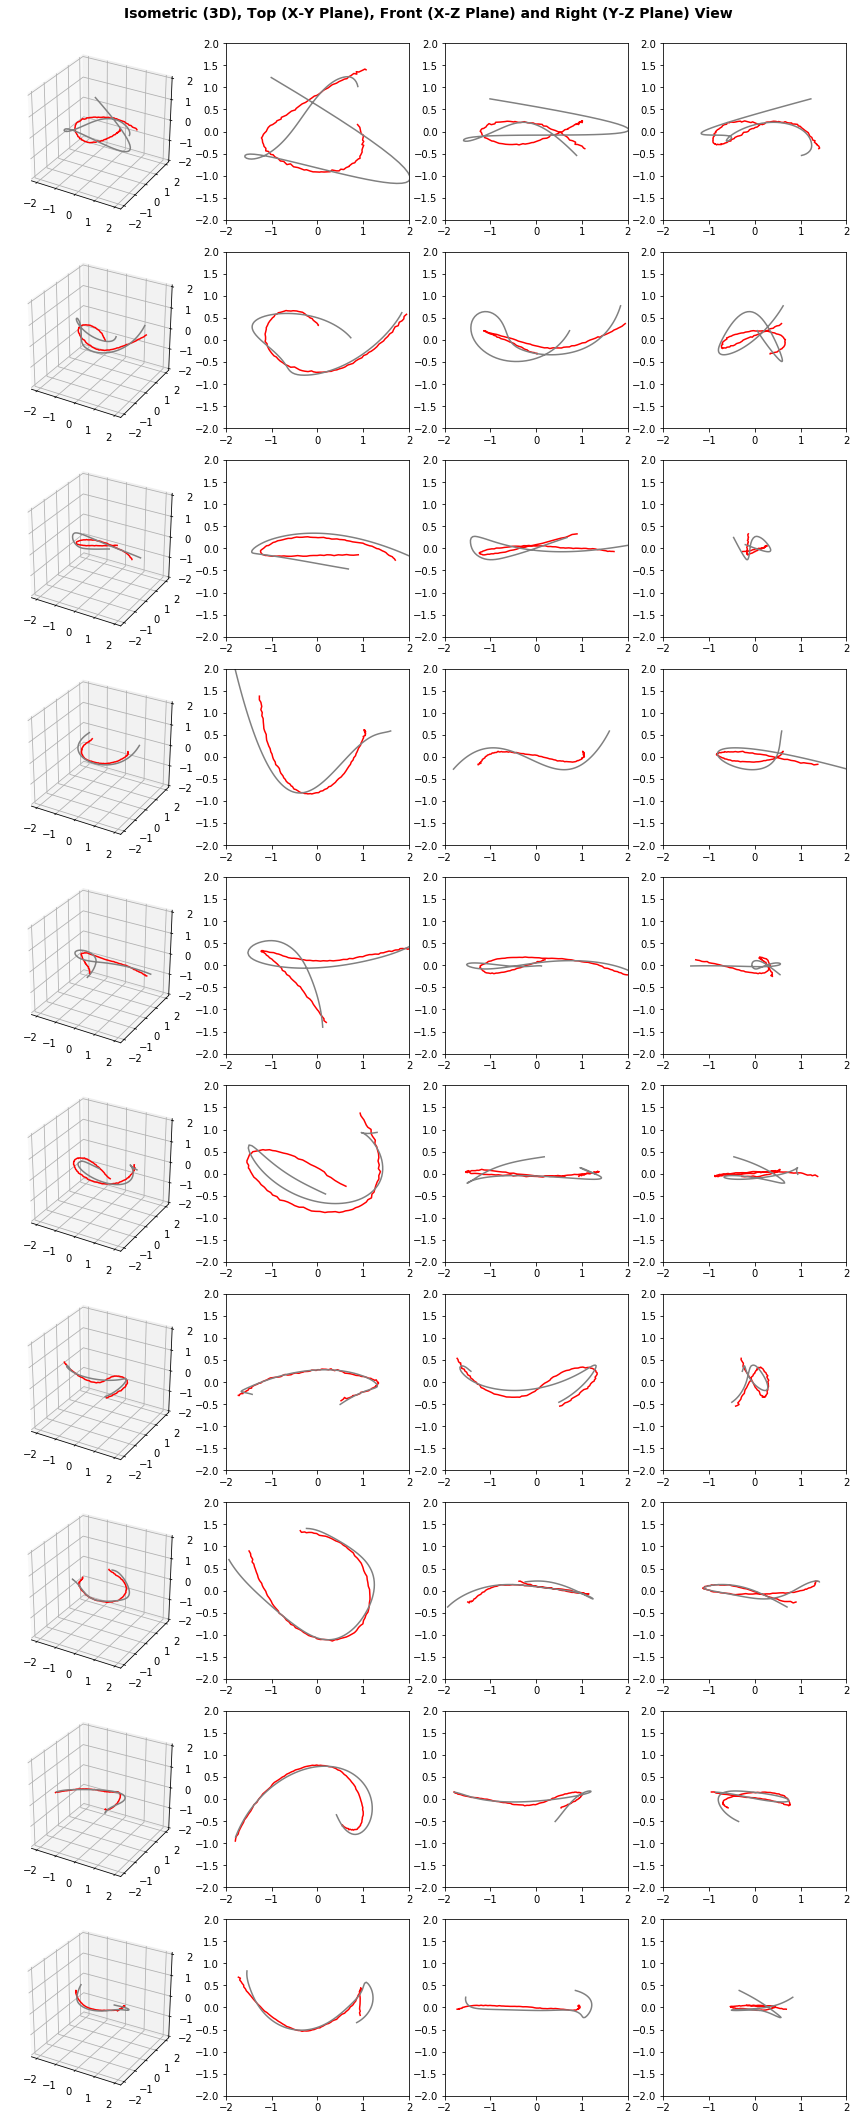

In [14]:
from keras.layers import Input, Dense, Lambda, Layer, Add, Multiply
from keras.losses import mse

class KLDivergenceLayer(Layer):

    """ Identity transform layer that adds KL divergence
    to the final model loss.
    """

    def __init__(self, *args, **kwargs):
        self.is_placeholder = True
        super(KLDivergenceLayer, self).__init__(*args, **kwargs)

    def call(self, inputs):
        mu, log_var = inputs
        kl_batch = - .5 * K.sum(1 + log_var - K.square(mu) - K.exp(log_var), axis=-1)
        self.add_loss(K.mean(kl_batch), inputs=inputs)
        return inputs

def reconstruction_loss(y_true, y_pred):
    return mse(y_true, y_pred)*300


def VAE_Z30():
    z_dim=30
    inp_curve=Input(shape=(100,3))

    # Encoding
    x=Flatten()(inp_curve)
    x=Dense(150, activation='relu')(x)
    #x=Dense(150, activation='relu')(x)
    #x=Dense(150, activation='relu')(x)

    z_mu = Dense(z_dim)(x)
    z_log_var = Dense(z_dim)(x)

    z_mu, z_log_var = KLDivergenceLayer()([z_mu, z_log_var])
    z_sigma = Lambda(lambda t: K.exp(.5*t))(z_log_var) # normalize log variance to std dev

    eps = Input(tensor=K.random_normal(shape=(K.shape(x)[0],z_dim)))
    z_eps = Multiply()([z_sigma, eps])
    encoded = Add()([z_mu, z_eps])

    # Decoding
    x=Dense(150, activation='relu')(encoded)
    #x=Dense(150, activation='relu')(x)
    #x=Dense(150, activation='relu')(x)
    x=Dense(300)(x)
    decoded=Reshape((100, 3))(x)

    vae = Model(inputs=[inp_curve, eps], outputs=decoded)
    encoder = Model(inputs=[inp_curve, eps], outputs=encoded)
    
    return vae, encoder

#resetRNG(0)
#x_train_3D=np.expand_dims(x_train, 4)
#x_test_3D=np.expand_dims(x_test, 4)
#AE,E,train_data =AE_analysis(VAE_Z30, 10, x_train, x_test, filename='VAE_Z30')
vae,_=VAE_Z30()
vae.summary()
vae.compile(optimizer='rmsprop', loss=reconstruction_loss)
train_data=vae.fit(x_train, x_train,
        shuffle=True,
        epochs=500,
        batch_size=128,
        validation_data=(x_test, x_test), verbose=0)
visualize_AE(vae, train_data, x_test)